# Чётенькое такси

## Описание проекта:
- Компания собрала исторические данные о заказах такси в аэропортах
-  Для привлечения больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час

## Цель работы:
- Необходимо построить модель для предсказания количества предсказания

## План работы:
 1. Загрузка и ресемплирование
 2. Анализ данных
 3. Обучение моделей
 4. Проверка данных на тестовой выборке

## Описание данных
- `datetime` - дата и время
- `num_orders` - количество заказов для заданного времени и даты

# Шаг 1. Загрузка и ресемплирование

- Загрузка нужных версий библиотек

In [1]:
!pip install -q scikit-learn
!pip install -q shap
!pip install -q matplotlib
!pip install -q seaborn
!pip install -q phik
!pip install -q yellowbrick
!pip install -q lightgbm
!pip install -q category_encoders


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


- Загрузка инструментов

In [2]:
# Библиотеки
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import lightgbm as lbm
import phik
import shap
import category_encoders
    
#Инструменты из библиотек
from category_encoders import BinaryEncoder, TargetEncoder
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, TimeSeriesSplit)
from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.model_selection import FeatureImportances
from sklearn.inspection import permutation_importance
from phik import phik_matrix
from statsmodels.tsa.stattools import adfuller
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVC
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import linear_model
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   MinMaxScaler,
                                   RobustScaler,
                                   LabelEncoder)
from sklearn.metrics import (r2_score,
                             roc_auc_score,
                             confusion_matrix,
                             mean_squared_error,
                             root_mean_squared_error,
                             mean_absolute_error,
                             precision_score,
                             accuracy_score,
                             recall_score,
                             make_scorer
                            )

In [3]:
RANDOM_STATE = 777
TEST_SIZE = 0.1

- На данном этапе выполним загрузку данных
- Проверим общую информацию о датасете
- Проверим правильность регистров названий столбцов
- Выполним предобработку

### Загрузка

In [4]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates = [0])

In [5]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


- Данные выглядят корректно
- Регистры названий столбцов нижние
- Типы столбцов также соответствуют своему смыслу в реальности

- Выполним формальные процедуры проверки на пропуски и дубликаты

In [7]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [8]:
df.duplicated().sum()

0

- Пропуски и дубликаты отсутствуют
- Неявные дубликаты рассматривать бессмысленно, так как в данных отсутствуют данные типа `object`
- Проведём ресемплирование данных по часу согласно указаниям в проекте

- Выделим столбец с датой и временем в качестве индекса, чтобы впоследствии было удобнее строить временные ряды

In [9]:
df = df.set_index('datetime')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Ресемплирование

- Проверим правильность порядка по дате и времени

In [11]:
df.index.is_monotonic_increasing

True

- Порядок расположения дат корректный
- Выполним ресемплирование по часу

In [12]:
df = df.resample('1h').sum()

In [13]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# Шаг 2. Анализ данных

- Визуализируем тренды, сезонность и остатки
- Сезонность рассмотрим в рамках одних суток, так как она обладает цикличностью каждые новые сутки

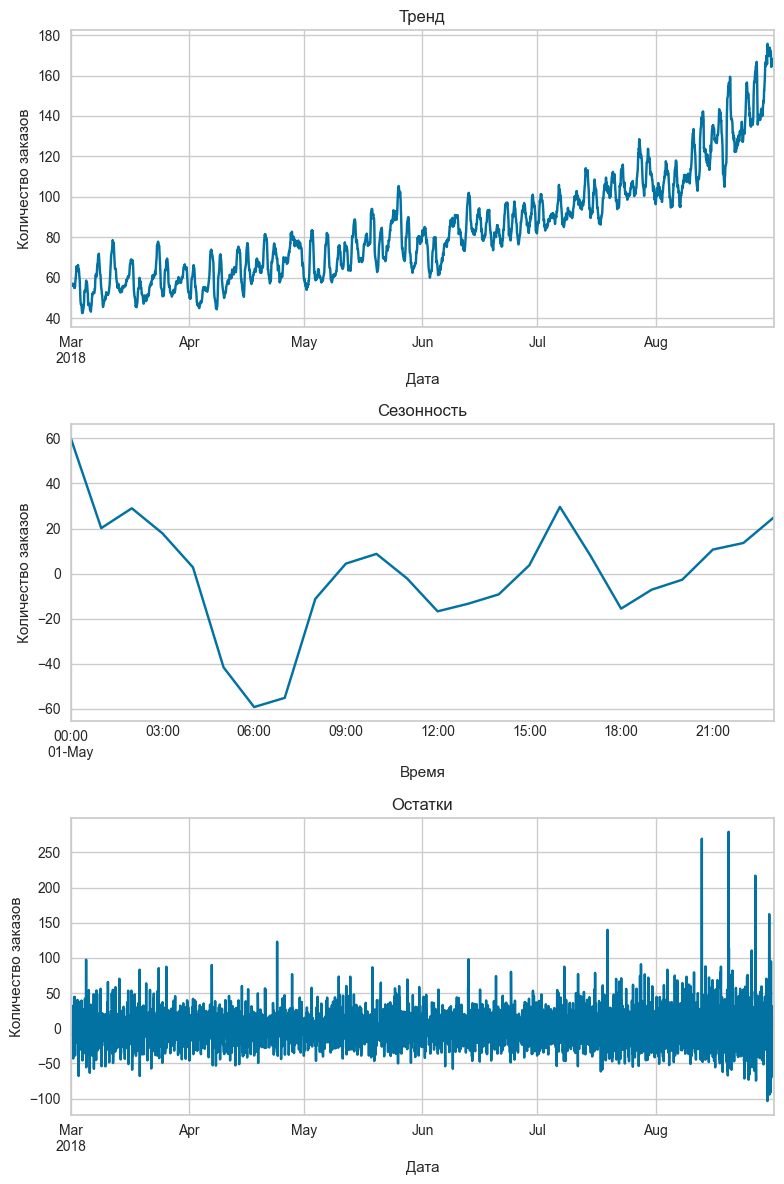

In [14]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(8, 12))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)

# Тренд
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.subplot(312)

# Сезонность
decomposed.seasonal['2018-05-01' : '2018-05-01'].plot(ax = plt.gca())
plt.title('Сезонность')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.subplot(313)

# Остатки
decomposed.resid.plot(ax = plt.gca())
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.tight_layout()

- По построенной визуализации видно, что в течение суток наибольшее число заказов такси приходится на ночь в период с 0 : 00 по 04 : 00
- На первом графике изображён восходящий тренд

- Изобразим скользящее среднее

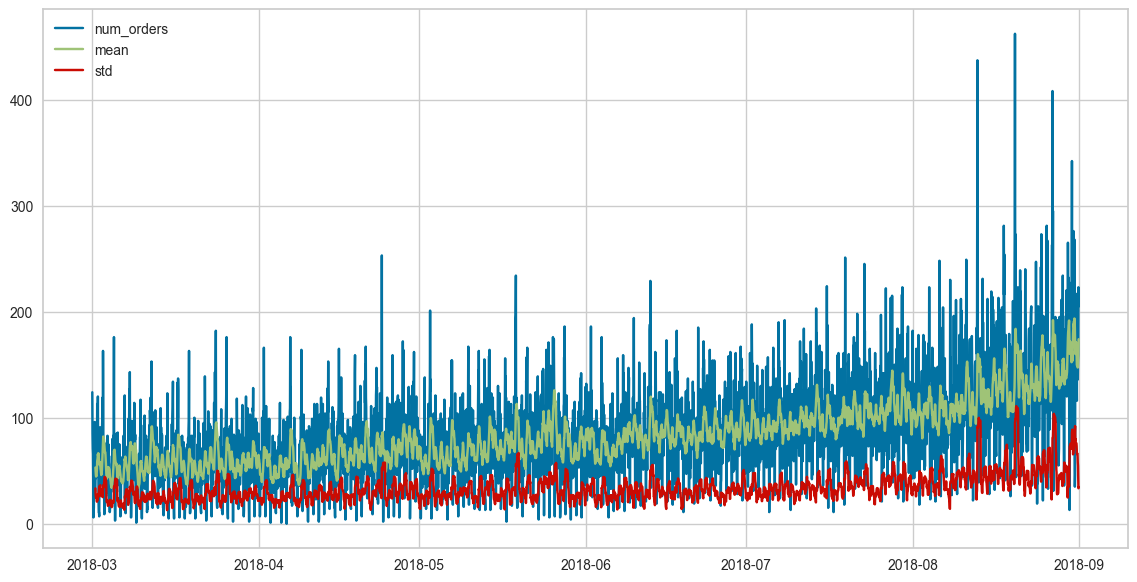

In [15]:
fig, ax = plt.subplots(figsize = (14, 7))
df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
ax.plot(df);
ax.legend(df);

In [16]:
result = adfuller(df['num_orders'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -3.0689242890279576
p-value: 0.0289400514026128
Critical Values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}


- Тест Дики - Фуллера показал значение p - value = 0.029, что меньше уровня значимости 0.05
- Таким образом, этот факт позволяет отвергнуть гипотезу о наличии единичных корней и даёт право считать, что временной ряд является стационарным

# Шаг 3. Обучение моделей

- Создадим функцию для генерирования признаков

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
# Создание сдвигов
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['lag_1'].rolling(rolling_mean_size).mean()
    return(data)    

In [18]:
df = make_features(df, 24, 5)

- Сдвиг осуществим на 24 строки ввиду того, что каждые 24 часа поведение временного ряда повторяется. Это было видно на графике сезонности на шаге 2

In [19]:
df.head()

,num_orders,mean,std,month,day,dayofweek,hour,lag_1,lag_2,lag_3,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,3,1,3,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,3,1,3,1,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,3,1,3,2,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,1,3,3,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,3,1,3,4,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Деление на выборки (тестовая составляет 10% от общего датасета)
- Отбросим из тренировочной выборки строки, в которых есть пропуски, появивишиеся из - за сдвига 

In [20]:
df = df.dropna()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   mean          4392 non-null   float64
 2   std           4392 non-null   float64
 3   month         4392 non-null   int32  
 4   day           4392 non-null   int32  
 5   dayofweek     4392 non-null   int32  
 6   hour          4392 non-null   int32  
 7   lag_1         4392 non-null   float64
 8   lag_2         4392 non-null   float64
 9   lag_3         4392 non-null   float64
 10  lag_4         4392 non-null   float64
 11  lag_5         4392 non-null   float64
 12  lag_6         4392 non-null   float64
 13  lag_7         4392 non-null   float64
 14  lag_8         4392 non-null   float64
 15  lag_9         4392 non-null   float64
 16  lag_10        4392 non-null   float64
 17  lag_11        4392 non-null

In [23]:
train, test = train_test_split(df, test_size = TEST_SIZE, shuffle = False)

In [24]:
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']

- Отбросим из тренировочной выборки строки, в которых есть пропуски, появивишиеся из - за сдвига 

In [25]:
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

- Проверим размерность тестовой и тренировочной выборок

In [26]:
text_list = ['тренировочной', 'тестовой']
text_signs = ['входных признаков', 'целевого признака']
dataset_list = [X_train, y_train, X_test, y_test]
for i in range(len(dataset_list)):
    print(f'Размерность {text_list[i // 2]} выборки {text_signs[i // 2]} составляет: {dataset_list[i].shape}')

Размерность тренировочной выборки входных признаков составляет: (3952, 31)
Размерность тренировочной выборки входных признаков составляет: (3952,)
Размерность тестовой выборки целевого признака составляет: (440, 31)
Размерность тестовой выборки целевого признака составляет: (440,)


- Отношение тренировочной и тестовой выборок менее 9, так как ранее были удалены пропуски, вызванные сдвигом
- В остальном размерности корректные

- Создадим пайплайн для поиска лучшей модели для предсказания
- Отмасштабируем количественные признаки, обусловенные сдвигом
- В качестве категориальных примем признаки `month`, `dayofweek`, `hour`. Остальные будут в роли количественных
- Для кодирования категориальных признаков воспользуемся кодировщиком `TargetEncoder`, так как он более универсальный

In [27]:
target_columns = [
               'month',
               'dayofweek',
               'hour'
                 ]

num_columns = list(set(X_train.columns.tolist()) - set(target_columns))

In [28]:
# SimpleImputer + OHE
target_pipe = Pipeline(
    [
        (
            'simpleImputer',
             SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (
            'target',
             TargetEncoder()
        )
    ]
)

In [29]:
# Пайплайн для кодирования и масштабирования данных
data_preprocessor = ColumnTransformer(
    [
        ('target', target_pipe, target_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder = 'passthrough'
)

- В качестве моделей используем LinearRegression, DecisionRegressor, LGBMRegressor

In [30]:
# Словарь для RandomizedSearchCV
param_distributions = [
            {
                # Описание DecisionTreeRegressor
                'models' : [DecisionTreeRegressor()],
                'models__max_depth' : range(20, 25),
                'models__min_samples_split' : range(5, 10),
                'preprocessor__num' : [StandardScaler()]
            },
            {
                # Описание LinearRegression
                'models' : [LinearRegression()],
                'preprocessor__num' : [StandardScaler()]
            },
            {
                # Описание LGBMRegressor
                'models' : [LGBMRegressor()],
                'models__num_leaves' : range(10, 15),
                'models__max_depth' : range(20, 25),
                'preprocessor__num' : [StandardScaler()]
            }
]

In [31]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression()) 
])

- Добавим кросс - валидацию `TimeSeriesSplit`

In [32]:
ts_cv = TimeSeriesSplit(n_splits = 9)

In [33]:
randomized_search = RandomizedSearchCV(
                        pipe_final,
                        param_distributions = param_distributions,
                        cv = ts_cv,
                        scoring = 'neg_root_mean_squared_error',
                        random_state = RANDOM_STATE,
                        n_iter = 20
                    )
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2432
[LightGBM] [Info] Number of data points in the train set: 397, number of used features: 30
[LightGBM] [Info] Start training from score 56.471033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3389
[LightGBM] [Info] Number of data points in the train set: 792, number of used features: 31
[LightGBM] [Info] Start training from score 57.103535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3759
[LightGBM] [Info] Number of data points in the train set: 1187, number of used features: 31
[LightGBM] [Info] Start traini

In [34]:
print('Метрика в результате кросс - валидации на тренировочной выборке:', round((randomized_search.best_score_), 3))
cv_parametres = [
                 'mean_score_time',
                 'mean_test_score',
                 'param_preprocessor__num',
                 'param_models__min_samples_split',
                 'param_models__num_leaves',
                 'param_models__max_depth',
                 'param_models'
                ]
for i in range(len(cv_parametres)):
    print(cv_parametres[i], ':', randomized_search.cv_results_.get(cv_parametres[i]))

Метрика в результате кросс - валидации на тренировочной выборке: -21.97
mean_score_time : [0.00538286 0.00564535 0.00867269 0.00673016 0.00492862 0.00629287
 0.00477107 0.00433832 0.00455507 0.00596465 0.00780649 0.00466371
 0.00721688 0.00510025 0.00477208 0.00455507 0.00552993 0.00510118
 0.00802562 0.00932977]
mean_test_score : [-30.55408686 -30.99712205 -21.96959493 -22.15287822 -30.72093775
 -22.05899772 -30.56050732 -29.96370775 -30.42886544 -22.04153431
 -22.15287822 -30.98844657 -22.15287822 -29.87279458 -30.34885074
 -31.0592512  -30.91653684 -30.96748885 -22.05899772 -21.96959493]
param_preprocessor__num : [StandardScaler() StandardScaler() StandardScaler() StandardScaler()
 StandardScaler() StandardScaler() StandardScaler() StandardScaler()
 StandardScaler() StandardScaler() StandardScaler() StandardScaler()
 StandardScaler() StandardScaler() StandardScaler() StandardScaler()
 StandardScaler() StandardScaler() StandardScaler() StandardScaler()]
param_models__min_samples_spli

- Значение метрики RMSE = 22 на тренировочной выборке удовлетворяет требованию проекта(метрика RMSE должна быть менее 48)
- Проверим в следующем шаге прямое требование проекта, а именно выполнение условия для метрики RMSE на тестовой выборке 

- По результатам автоматизированного поиска RandomSearchCV лучшей моделью оказалась LGBMRegressor c гиперпараметрами:
    + Максимальная глубина дерева max_depth = 20
    + Число листьев num_leaves = 14

# Шаг 4. Проверка данных на тестовой выборке

- Проверим метрику

In [35]:
y_pred = randomized_search.predict(X_test)
print('Значение метрики RMSE лучшей модели на тестовых данных:', round(root_mean_squared_error(y_test, y_pred), 3))

Значение метрики RMSE лучшей модели на тестовых данных: 41.7


- Значение метрики RMSE на тестовой выборке соответствует требованиям проекта и составляет 41.7

## Выводы

- Анализируя временной ряд числа заказов(сезонность) было замечено, что каждые сутки число заказов имеет одинаковый закон или иными словами присутствует цикличность
- В период с марта по сентябрь 2018 года наблюдается рост числа заказов, восходящий тренд. Так что кроме особенностей распределения числа заказов в течение суток(к примеру, в ночной период с 0 : 00 по 04 : 00 нагрузка наибольшая), необходимо учитывать и глобальный рост компании
- Модель учитывает сразу оба вышеперечисленных фактора и предсказывает число заказов с допустимым показателем (метрикой) RMSE = 41.7
- Таким образом, благодаря информации о числе заказов, которое предскажет модель, можно подобрать нужное число водителей, чтобы охватить всех потенциальных клиентов в течение следующего часа